In [1]:
import pandas as pd  

import plotly.graph_objs as go


In [2]:
# Skip initial header rows and load actual data
df_clean = pd.read_excel("20250520_Historical_Average_Daily_Conventional_Gilt_Yields.xlsx", sheet_name=0, skiprows=3)

# Rename columns for clarity
df_clean.columns = ['Date', 'Short', 'Medium', 'Long', 'Ultra-Long']

# Drop any rows with missing dates or yields
df_clean = df_clean.dropna(subset=['Date', 'Medium'])

# Set date as index and convert yields to numeric
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['Medium'] = pd.to_numeric(df_clean['Medium'], errors='coerce')
df_clean = df_clean.set_index('Date')

# Preview cleaned medium-term yield data
medium_yields = df_clean[['Medium']]
medium_yields.head()

,Medium
Date,
2010-01-01,4.062854
2010-02-01,4.092791
2010-03-01,4.015507
2010-04-01,4.058127
2010-05-01,3.712070


In [3]:
import numpy as np
from scipy.optimize import minimize

# Prepare yield data: convert percent to decimal
yields = medium_yields['Medium'].values / 100
dt = 1 / 12  # Monthly data

# Define CIR log-likelihood function
def cir_log_likelihood(params, rates, dt):
    a, b, sigma = params
    r = rates[:-1]
    r_next = rates[1:]
    expected = r + a * (b - r) * dt
    variance = sigma**2 * r * dt
    # Prevent division by zero or negative variance
    variance = np.maximum(variance, 1e-8)
    ll = -0.5 * np.sum(np.log(2 * np.pi * variance) + ((r_next - expected)**2 / variance))
    return -ll  # Negative log-likelihood

# Initial parameter guess
initial_guess = [0.1, 0.03, 0.02]

# Parameter bounds: all must be > 0
bounds = [(1e-4, None)] * 3

# Run optimization
result = minimize(cir_log_likelihood, initial_guess, args=(yields, dt), bounds=bounds)
a_est, b_est, sigma_est = result.x

a_est, b_est, sigma_est


(np.float64(0.13366788060389823),
 np.float64(0.0239158337517703),
 np.float64(0.05288767854024473))

In [4]:
import matplotlib.pyplot as plt

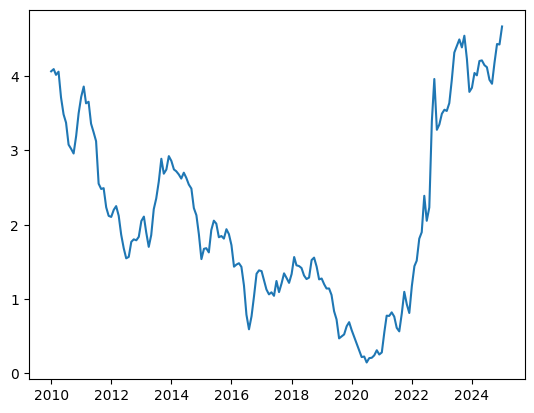

In [5]:
plt.plot(df_clean['Medium'])

In [6]:
import pandas as pd
import plotly.graph_objs as go

# Set simulation parameters
n_steps = 60  # 5 years of monthly steps
n_paths = 90   # simulate multiple paths
r0 = yields[-1]  # start from the most recent observed rate

# CIR simulation function
def simulate_cir_paths(a, b, sigma, r0, n_steps, dt, n_paths=1):
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0] = r0
    for j in range(n_paths):
        for i in range(1, n_steps + 1):
            r_prev = paths[i - 1, j]
            dr = a * (b - r_prev) * dt + sigma * np.sqrt(max(r_prev, 0)) * np.random.normal() * np.sqrt(dt)
            paths[i, j] = max(r_prev + dr, 0)  # ensure non-negative
    return paths

# Run simulation
simulated_paths = simulate_cir_paths(a_est, b_est, sigma_est, r0, n_steps, dt, n_paths)

# Create time axis
dates = pd.date_range(start=medium_yields.index[-1], periods=n_steps + 1, freq='M')

# Create interactive plot
fig = go.Figure()
for i in range(n_paths):
    fig.add_trace(go.Scatter(x=dates, y=simulated_paths[:, i] * 100, mode='lines', name=f'Path {i+1}'))

fig.update_layout(
    title='Simulated UK Medium-Term Gilt Yields (CIR Model)',
    xaxis_title='Date',
    yaxis_title='Yield (%)',
    template='plotly_dark',
    height=500
)

fig.show()


/var/folders/z8/lgc1tbbd1gv1xx7vw9q451x80000gn/T/ipykernel_7305/1217144271.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=medium_yields.index[-1], periods=n_steps + 1, freq='M')


In [7]:
# Convert the simulated paths to a DataFrame for export
simulated_df = pd.DataFrame(simulated_paths * 100, index=dates, columns=[f'Path_{i+1}' for i in range(n_paths)])
simulated_df.index.name = "Date"

# Save to CSV
csv_path = "./simulated_cir_gilt_yields.csv"
simulated_df.to_csv(csv_path)

csv_path


'./simulated_cir_gilt_yields.csv'

'./simulated_cir_gilt_yields.gif'

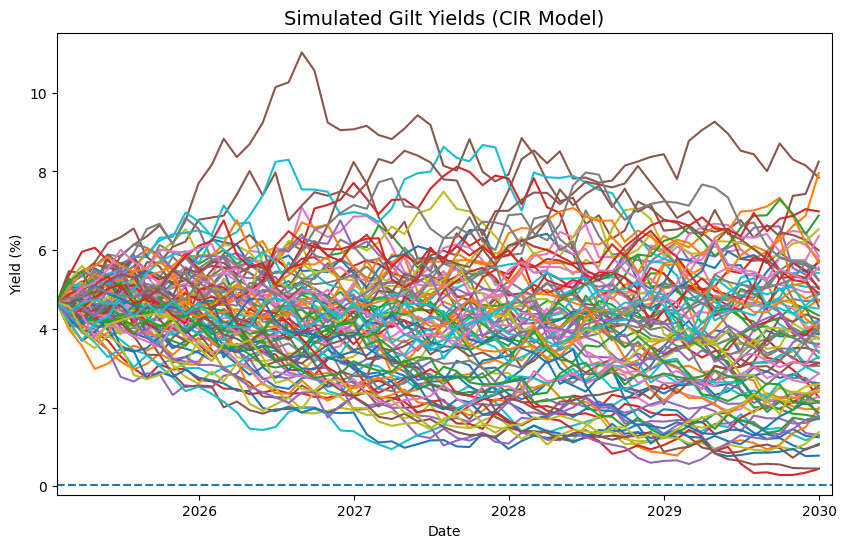

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(simulated_df.index[0], simulated_df.index[-1])
ax.set_ylim(simulated_df.min().min() - 0.5, simulated_df.max().max() + 0.5)
ax.set_title("Simulated Gilt Yields (CIR Model)", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Yield (%)")
ax.hlines(b_est*100,simulated_df.index[0], simulated_df.index[-1],linestyles='--')


# Create line objects for each path
lines = [ax.plot([], [], label=col)[0] for col in simulated_df.columns]
l=ax.legend()
l.remove()

# Initialization function
def init():
    for line in lines:
        line.set_data([], [])
    return lines

# Animation function
def animate(i):
    for j, line in enumerate(lines):
        line.set_data(simulated_df.index[:i], simulated_df.iloc[:i, j])
    return lines

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(simulated_df), interval=100, blit=True)

# Save as GIF
gif_path = "./simulated_cir_gilt_yields.gif"
ani.save(gif_path, writer='pillow')

gif_path


In [ ]:
pip install plotly-gif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 MB 50.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
